In [1]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
#load mnist dataset

Using TensorFlow backend.


In [2]:
# Setup train and test splits
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training label shape: ", y_train.shape) # (60000,) -- 60000 numbers (all 0-9)
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# splitting dataset for faster learning and debugging
X_train, _,_,_,_,_ = np.split(X_train,6) #
y_train, _,_,_,_,_ = np.split(y_train,6)
# input and output shape
input_shape = X_train[1].shape
num_classes = 10
# Flatten the images
image_vector_size = 28*28
print(image_vector_size)
X_train = X_train.reshape(X_train.shape[0], image_vector_size)
X_test = X_test.reshape(X_test.shape[0], image_vector_size)
print(y_train.shape)
print(X_train.shape)

Training label shape:  (60000,)
First 5 training labels:  [5 0 4 1 9]
784
(10000, 10)
(10000, 784)


# DNA Parameter to optimize

depth = [1,2,3,4,5,6,7,8,9,10] <br>
neurons_per_layer = [16,32,64,128,256,512,1024]  <br>
activations = ["tanh","softmax","relu","sigmoid"] #"leakyrelu","exponential","elu","selu","softplus","softsign","hard_sigmoid","linear" <br>
optimizer = ["sgd","rmsprop","adagrad","adadelta","adam","adamax","nadam"], <br>
losses =["mean_squared_error","mean_absolute_error","mean_absolute_percentage_error","mean_squared_logarithmic_error","squared_hinge","hinge","categorical_hinge","logcosh","categorical_crossentropy","sparse_categorical_crossentropy","binary_crossentropy","kullback_leibler_divergence","poisson","cosine_proximity"] <br>
#learning_rate 


##### not using loss: "sparse_categorical_crossentropy" since it messes with the shape of the output layer

In [48]:
# DNA[0] = depth
# DNA[1] = neurons_per_layer
# DNA[2] = activations
# DNA[3] = optimizer
# DNA[4] = losses
DNA_parameter = [[5,6,7,8,9,10],
                 [16,32,64,128,256,512,1024],
                 ["tanh","softmax","relu","sigmoid","elu","selu","softplus","softsign","hard_sigmoid","linear"], #"leakyrelu",
                 ["sgd","rmsprop","adagrad","adadelta","adam","adamax","nadam"],
                 ["mean_squared_error","mean_absolute_error","mean_absolute_percentage_error","mean_squared_logarithmic_error","squared_hinge","hinge","categorical_hinge","logcosh","categorical_crossentropy","binary_crossentropy","kullback_leibler_divergence","poisson","cosine_proximity"] #"sparse_categorical_crossentropy",
                ]

In [91]:
class Network:
    def __init__(self,input_shape,classes,DNA_param,epochs):
        
        self.architecture_DNA = [] # to save current parameters
        self.fitness = []
        self.acc_history = []
        self.input_shape = input_shape 
        self.classes = classes
        self.epochs = epochs

        
        # unfold DNA_parameters:
        depth = DNA_param[0]
        neurons_per_layer = DNA_param[1]
        activations = DNA_param[2]
        optimizer = DNA_param[3]
        losses = DNA_param[4]
        
        model = Sequential()
        # Building the init network with random choices: 
        network_depth = np.random.choice(depth)
        self.architecture_DNA.append(network_depth)

        for i in range(network_depth):
            if i == 0:
                neurons = np.random.choice(neurons_per_layer)
                activation  = np.random.choice(activations)
                self.architecture_DNA.append([neurons, activation])
                model.add(Dense(neurons,input_shape = (self.input_shape,), activation  = activation))
            if i == network_depth - 1:
                activation  = np.random.choice(activations)
                self.architecture_DNA.append(activation)
                model.add(Dense(self.classes, activation = activation ))
            else:
                neurons = np.random.choice(neurons_per_layer)
                activation  = np.random.choice(activations)
                self.architecture_DNA.append([neurons,activation])
                model.add(Dense(neurons, activation  = activation))
        
        loss=np.random.choice(losses)
        optimizer=np.random.choice(optimizer)
        self.architecture_DNA.append([loss,optimizer])
        model.compile(loss=loss, optimizer= optimizer, metrics=['accuracy'])
        self.model = model
        
        ### STRUCTURE OF ACHITECTURE DNA ###
        # architecture_DNA[0] = Depth
        # architecture_DNA[1] = Input_layer with: [0] = neurons, [1] = activation
        # architecture_DNA[2 to Depth-1*] = Hidden layer with: [0] = neurons, [1] = activation   
        # architecture_DNA[Depth] = Output layer activation
        # architecture_DNA[-1] = Hyperparameter with: [0] = loss, [1] = optimizer
        
        # *Depth-1 last hidden layer since last layer is output layer
        ####################################
    
    def create_children(self, children_DNA):
        model = Sequential()
        ####################################################################################
        # unfold children DNA:                                                             #
        # children_DNA[0] = Depth                                                          #
        # children_DNA[1] = Input_layer with: [0] = neurons, [1] = activation              #
        # children_DNA[2 to Depth-1*] = Hidden layer with: [0] = neurons, [1] = activation # 
        # children_DNA[Depth] = Output layer activation                                    #
        # children_DNA[-1] = Hyperparameter with: [0] = loss, [1] = optimizer              #
        ####################################################################################
        
        #print("DNA_length: ", len(children_DNA))
        children_depth = children_DNA[0]
        #print("Depth: ", children_depth)
        #print(children_DNA)
        for i in range(children_depth):
            if i == 0:
                #Input Layer
                model.add(Dense(children_DNA[1][0],input_shape = (self.input_shape,), activation = children_DNA[1][1]))
            if i == children_depth -1:
                model.add(Dense(self.classes, activation = children_DNA[children_depth]))
            else:
                #print(children_DNA[i+1])
                if i != children_depth -1:
                    model.add(Dense(children_DNA[i+1][0], activation = children_DNA[i+1][1]))
        model.compile(loss = children_DNA[-1][0], optimizer = children_DNA[-1][1], metrics=['accuracy'])
        self.model = model
        self.architecture_DNA = children_DNA
        
        
    def give_fitness(self):
        return self.fitness
    
        
    def train(self):
        #start = time.time()
        self.model.fit(X_train,y_train, batch_size = 32, epochs = self.epochs, verbose = 1,shuffle = True) #, validation_data =(X_test, y_test)
        #end = time.time()
        #self.fitness[0] = end-start
 
    def test(self):
        loss, acc = self.model.evaluate(X_test,y_test)
        self.fitness = acc
        self.acc_history.append(acc)
    
    def give_DNA(self):
        return self.architecture_DNA
    
    def architecture(self):
        self.model.summary()

In [94]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations = 50, Epochs = 2):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.training_epochs = Epochs
        self.population = None
        self.children_population_DNA = []
        self.acces = []
        self.norm_acces = []
        
    def create_population(self):
        self.population = [Network(image_vector_size, num_classes, DNA_parameter,self.training_epochs) for i in range(self.population_size)]
    
    def train_generation(self):
        for member in self.population:
                member.train()
                
    def predict(self):
        for member in self.population:
                member.test()
                self.acc.append(member.give_fitness())
    
    def normalize(self):
        sum_ = sum(self.acc)
        self.norm_acc = [i/sum_ for i in self.acc] 
        #print("\nNormalization sum: ",sum(self.norm_acc))
        #assert sum(self.norm_acc) == 1
        
    def clear_losses(self):
        self.norm_acc = []
        self.acc = []
        
    def mutate(self):
        for child_DNA in self.children_population_DNA:
            for i in range(len(child_DNA)):
                if np.random.random() < self.mutation_rate:
                    print("\nMutation!")
                    if i == 0:
                        new_depth = np.random.choice(DNA_parameter[0])
                        child_DNA[0] = new_depth
                    
                    if i == len(child_DNA)-2:
                        new_output_activation = np.random.choice(DNA_parameter[2])
                        child_DNA[-2] = new_output_activation
                    
                    if i == len(child_DNA)-1:
                        # random flip if loss or activation shall be changed
                        if np.random.random() < 0.5:
                            new_loss = np.random.choice(DNA_parameter[4])
                            child_DNA[-1][0] = new_loss
                        else:
                            new_optimizer = np.random.choice(DNA_parameter[3])
                            child_DNA[-1][1] = new_optimizer
                    if i != 0 and i !=len(child_DNA)-2 and i != len(child_DNA)-1:
                    #else:
                        # 3/2 flif if number of neurons or activation function mutates:
                        #print(child_DNA)
                        if np.random.random() < 0.33:
                            #print(child_DNA[i][1])
                            new_activation = np.random.choice(DNA_parameter[2])
                            #print(new_activation)
                            child_DNA[i][1] = new_activation
                        else:
                            #print(child_DNA[i][0])
                            new_neuron_count = np.random.choice(DNA_parameter[1])
                            child_DNA[i][0] = new_neuron_count
                            #print(new_neuron_count)
                    #print("After mutation ", child_DNA)

    def reproduction(self):
        """ 
        Reproduction through midpoint crossover method 
        """
        population_idx = [i for i in range(len(self.population))]
        for i in range(len(self.population)):
        #selects two parents probabilistic accroding to the fitness score
            if sum(self.norm_acc) != 0:
                parent1 = np.random.choice(population_idx, p = self.norm_acc)
                parent2 = np.random.choice(population_idx, p = self.norm_acc)
            else:
              # if there are no "best" parents choose randomly 
                parent1 = np.random.choice(population_idx)
                parent2 = np.random.choice(population_idx)

            # picking random midpoint for crossing over name/DNA
            parent1_DNA = self.population[parent1].give_DNA()
            parent2_DNA = self.population[parent2].give_DNA()
            #print(parent1_DNA)
            
            mid_point_1 = np.random.choice([i for i in range(2,len(parent1_DNA)-2)])
            mid_point_2 = np.random.choice([i for i in range(2,len(parent2_DNA)-2)])
            # adding DNA-Sequences of the parents to final DNA
            child_DNA = parent1_DNA[:mid_point_1] + parent2_DNA[mid_point_2:]
            new_nn_depth = len(child_DNA)-2 # minus 2 because of depth parameter[0] and loss parameter[-1]
            child_DNA[0] = new_nn_depth
            self.children_population_DNA.append(child_DNA)
        # old population gets the new and proper weights
        self.mutate()
        keras.backend.clear_session() ## delete old models to free memory
        for i in range(len(self.population)):
            self.population[i].create_children(self.children_population_DNA[i])
        
        
    
    def run_evolution(self):
        for episode in range(self.generations):
            print("\n--- Generation {} ---".format(episode))
            self.clear_losses()
            self.train_generation()
            self.predict()
            if episode != self.generations -1:
                self.normalize()
                self.reproduction()
                
            else:
                pass
            self.children_population_DNA = []
        # plotting history:
        for a in range(self.generations):
            for member in self.population:
                plt.plot(member.acc_history)
        plt.xlabel("Generations")
        plt.ylabel("Accuracy")
        plt.show()


--- Generation 0 ---
Epoch 1/1
10000/10000 [==============================] - 1s - loss: -0.0493 - acc: 0.3589     
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 1.9455 - acc: 0.0951     
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 1.0952 - acc: 0.1036     
Epoch 1/1
 9056/10000 [==========================>...] - ETA: 0s
Mutation!
[15, [128, 'hard_sigmoid'], [128, 'hard_sigmoid'], [64, 'tanh'], [256, 'linear'], [512, 'selu'], [16, 'softsign'], [64, 'linear'], [32, 'selu'], [256, 'linear'], [512, 'selu'], [16, 'softsign'], [64, 'linear'], [32, 'selu'], [128, 'softmax'], 'softsign', ['cosine_proximity', 'adagrad']]

Mutation!
[15, [128, 'hard_sigmoid'], [128, 'hard_sigmoid'], [128, 'tanh'], [256, 'linear'], [512, 'selu'], [16, 'softsign'], [64, 'linear'], [32, 'selu'], [256, 'linear'], [512, 'selu'], [16, 'softsign'], [64, 'linear'], [32, 'selu'], [128, 'softmax'], 'softsign', ['cosine_proximity', 'adagrad']]

Mutation!
[13, [1024, 'elu'], [

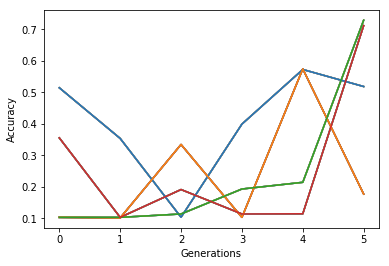

In [93]:
GA = GeneticAlgorithm(population_size = 4,mutation_rate = 0.03, generations = 6,Epochs=1)
GA.create_population()
GA.run_evolution()

# TODO:
# fixing little bugs and Errors with mutiations
# FItness implying training time (and loss?)
# logging-data or architecture -- Process
# liveplot?
# 